In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import openmatrix as omx

In [2]:
plt.style.use("default")

In [3]:
data_path = Path("../data")
with omx.open_file(data_path/"skims.omx") as skims:
    dists = pd.DataFrame(skims["CAR_DIST__OP"])
    dists.columns = dists.columns + 1
    dists.index = dists.index + 1

In [4]:
asim_path = Path("../output")
asim_results = pd.read_csv(asim_path.joinpath("final_longdist_tours.csv")) # tours
asim_persons = pd.read_csv(asim_path.joinpath("final_persons.csv"))
asim_hh = pd.read_csv(asim_path.joinpath("final_households.csv"))

In [5]:
oldpath = Path("../legacy-output")
old_results = pd.read_csv(oldpath/"zzLDTPersonTours.csv.gz") # tours
old_persons = pd.read_csv(oldpath/"zzPersonData.csv.gz")
old_hh = pd.read_csv(oldpath/"zzHouseholdData.csv.gz")

In [6]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Amount of Unique Households going on Individual Trips

In [7]:
print(asim_results[asim_results.tour_type != "longdist_household"].shape)
print(asim_results[asim_results.tour_type != "longdist_household"].household_id.unique().shape)

(18125, 24)
(17691,)


In [8]:
print(old_results[old_results.tourPurpose != "HOUSEHOLD"].shape)
print(old_results[old_results.tourPurpose != "HOUSEHOLD"].hhID.unique().shape)

(83024, 18)
(62328,)


# Tour Generation Comparison

In [9]:
income_bins = [-np.inf, 20_000, 40_000, 60_000, 90_000, np.inf]
old_hh["HHINC5"] = pd.cut(old_hh.HINC, income_bins)
asim_hh["HHINC5"] = pd.cut(asim_hh.INCOME, income_bins)
pd.concat(
    [old_hh.HHINC5.value_counts().rename("Java"),
     asim_hh.HHINC5.value_counts().rename("ASim")
     ],
    axis=1,
).sort_index().style.set_caption("Total Households by Income").format("{:,}").background_gradient()

,Java,ASim
"(-inf, 20000.0]","389,437","103,564"
"(20000.0, 40000.0]","429,206","113,585"
"(40000.0, 60000.0]","337,662","89,977"
"(60000.0, 90000.0]","360,701","95,752"
"(90000.0, inf]","364,044","97,122"


In [10]:
title = "HH LDT Rates by Income"
hh_ldt_rates = pd.concat(
    [
        old_hh.pivot_table(
            values="LD_HOUSEHOLD_TOUR",
            index="HHINC5",
        ).set_axis(["Java"], axis=1),
        asim_hh.pivot_table(
            values="ldt_tour_gen_household",
            index="HHINC5",
        ).set_axis(["ASim"], axis=1),
    ],
    axis=1,
) * 100
hh_ldt_rates.style.background_gradient(vmin=0).set_caption(title)

,Java,ASim
HHINC5,,
"(-inf, 20000.0]",0.097577,1.686880
"(20000.0, 40000.0]",0.136764,1.990580
"(40000.0, 60000.0]",0.156369,2.142770
"(60000.0, 90000.0]",0.226226,2.626577
"(90000.0, inf]",0.184868,1.819361


In [11]:
title = "HH LDT Rates by Household Size"
hh_ldt_rates = pd.concat(
    [
        old_hh.pivot_table(
            values="LD_HOUSEHOLD_TOUR",
            index=old_hh.PERSONS.clip(upper=5).rename("N_PERSONS"),
        ).set_axis(["Java"], axis=1),
        asim_hh.pivot_table(
            values="ldt_tour_gen_household",
            index=asim_hh.hhsize.clip(upper=5).rename("N_PERSONS"),
        ).set_axis(["ASim"], axis=1),
    ],
    axis=1,
) * 100
hh_ldt_rates.style.background_gradient(vmin=0).set_caption(title)

,Java,ASim
N_PERSONS,,
1,0.156969,2.295495
2,0.234395,2.637654
3,0.106351,1.582984
4,0.074866,1.099455
5,0.073546,1.023467


In [12]:
title = "Relative Change in HH LDT Rates from Java to ASim"
hh_ldt_rates = pd.concat(
    [
        old_hh.pivot_table(
            values="LD_HOUSEHOLD_TOUR",
            index="HHINC5",
            columns=old_hh.PERSONS.clip(upper=5).rename("N_PERSONS"),
        )
        .unstack()
        .rename("Java"),
        asim_hh.pivot_table(
            values="ldt_tour_gen_household",
            index="HHINC5",
            columns=asim_hh.hhsize.clip(upper=5).rename("N_PERSONS"),
        )
        .unstack()
        .rename("ASim"),
    ],
    axis=1,
)
figure = (
    hh_ldt_rates.eval("ASim/Java")
    .unstack()
    .style.background_gradient(axis=None)
    .set_caption(title)
)
figure

HHINC5,"(-inf, 20000.0]","(20000.0, 40000.0]","(40000.0, 60000.0]","(60000.0, 90000.0]","(90000.0, inf]"
N_PERSONS,,,,,
1,18.086612,14.888124,11.840943,13.191218,10.243593
2,14.567272,12.766645,13.430789,10.023014,9.260341
3,21.032466,23.974423,18.083070,14.003354,10.520823
4,21.931026,16.883623,20.016883,15.750285,11.228614
5,14.994687,22.934422,15.246344,14.689717,10.365320


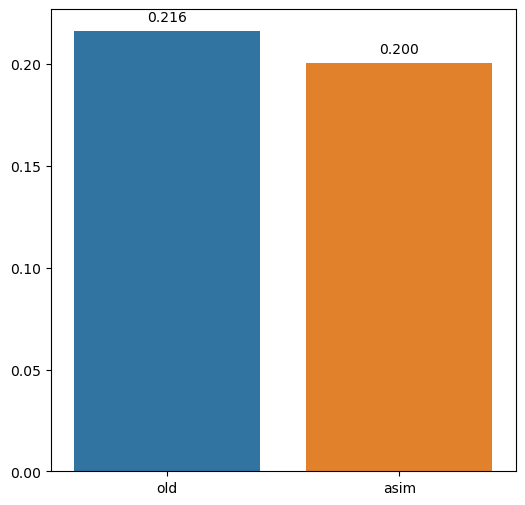

In [13]:
# proportion of people that had generated other trips
old = len(old_persons[(old_persons.LD_INDICATOR_OTHER == 1)]) / len(old_persons)
asim = len(asim_persons[asim_persons.ldt_tour_gen_person_OTHER]) / len(asim_persons)
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=["old", "asim"], y = [old, asim])
add_value_labels(ax)

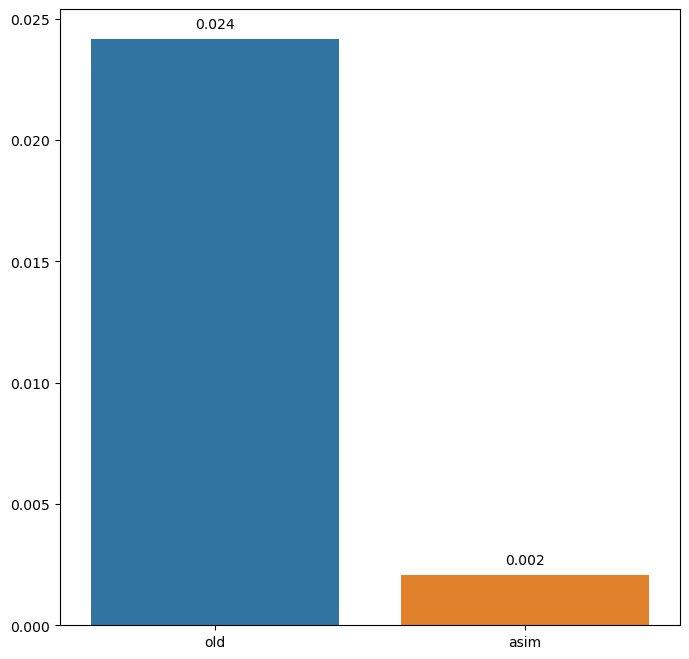

In [14]:
# proportion of people that had generated workrealted trips
old = len(old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)]) / len(old_persons)
asim = len(asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED]) / len(asim_persons)
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=["old", "asim"], y = [old, asim])
add_value_labels(ax)

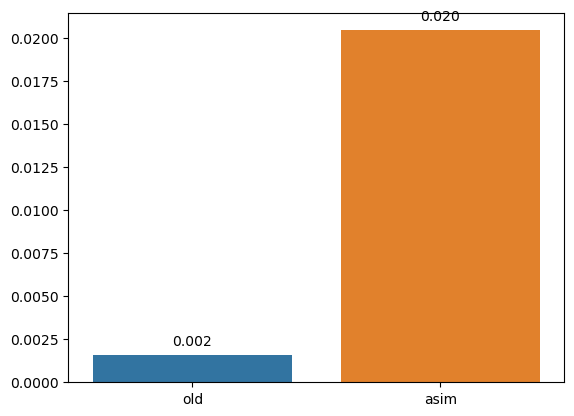

In [15]:
# proportion of households that had generated household trips
old = len(old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]) / len(old_hh)
asim = len(asim_hh[asim_hh.ldt_tour_gen_household]) / len(asim_hh)
ax = sns.barplot(x=["old", "asim"], y = [old, asim])
add_value_labels(ax)

Asim seems ot significantly undergenerate workrelated LDT trips and overgenerates household LDT trips

In [16]:
# distribution of generated tour types in asim
asim_results["tour_type"].value_counts()

longdist_person_OTHER          17770
longdist_household               744
longdist_person_WORKRELATED      355
Name: tour_type, dtype: int64

In [17]:
# distribution of generated tour types in old model
old_results["tourPurpose"].value_counts()

OTHER          69016
WORKRELATED    14008
HOUSEHOLD        518
Name: tourPurpose, dtype: int64

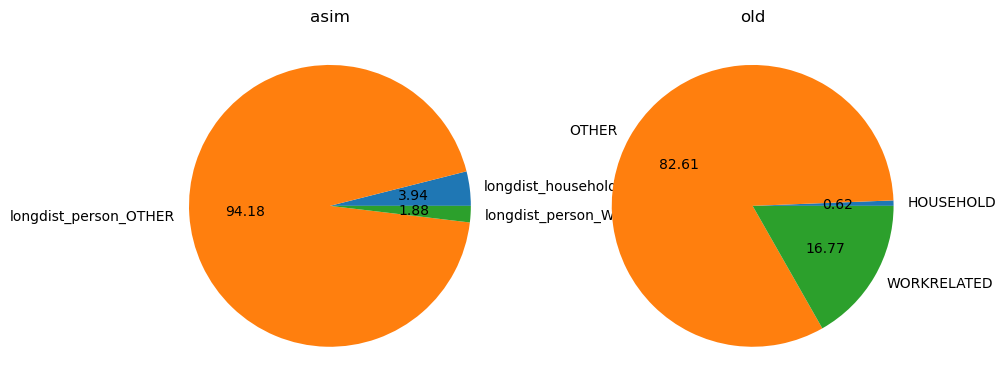

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_results["tour_type"].value_counts().sort_index()
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
axs[0].title.set_text("asim")
temp = old_results["tourPurpose"].value_counts().sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

# comparison of ldt pattern

In [19]:
# household patterns (for households that were generated tours)
asim_hh[asim_hh.ldt_tour_gen_household]["ldt_pattern_household"].value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})

no tour     8682
away         792
complete     279
end          236
begin        229
Name: ldt_pattern_household, dtype: int64

In [20]:
old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]["LD_HOUSEHOLD_PATTERN"].value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"})

no tour     2346
away         404
begin        136
complete      92
end            6
Name: LD_HOUSEHOLD_PATTERN, dtype: int64

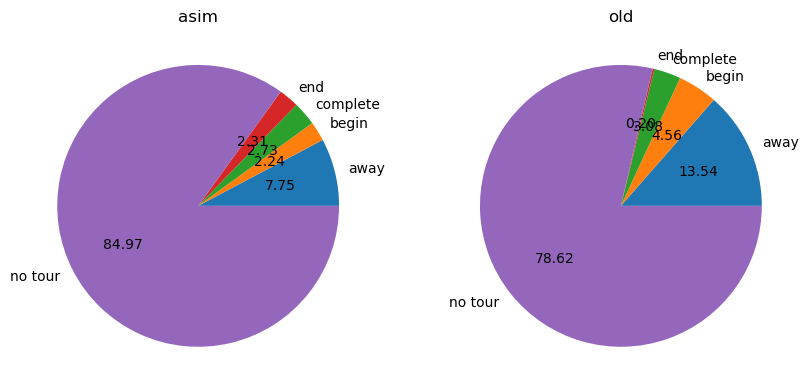

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_hh[asim_hh.ldt_tour_gen_household]["ldt_pattern_household"].value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}).sort_index()
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
temp = old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]["LD_HOUSEHOLD_PATTERN"].value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"}).sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

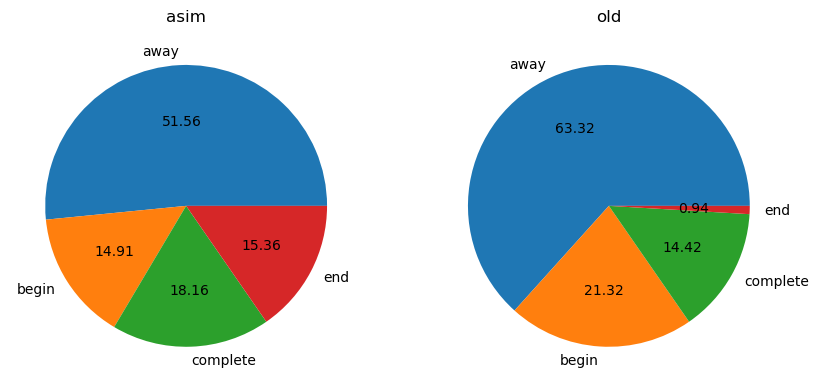

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_hh[asim_hh.ldt_tour_gen_household]["ldt_pattern_household"].value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}).drop("no tour").sort_index()
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
axs[0].title.set_text("asim")
temp = old_hh[old_hh.LD_HOUSEHOLD_TOUR == 1]["LD_HOUSEHOLD_PATTERN"].value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"}).drop("no tour").sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

For some reason, the distribution of household patterns vary between asim/old, despite the model being frequency based

# workrelated patterns

In [23]:
# enforcing pattern hierarchy
old_persons["ldt_pattern"] = np.where(old_persons["LD_INDICATOR_WORKRELATED"] == 1, old_persons["LD_TOUR_PATTERN_WORKRELATED"], old_persons["LD_TOUR_PATTERN_OTHER"])

In [24]:
# this ordering is probably right
old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)].ldt_pattern.value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"})

no tour     85231
away        10769
complete     6414
begin        4026
end          3568
Name: ldt_pattern, dtype: int64

In [25]:
asim_persons["ldt_pattern"] = 0

In [26]:
# merging bitshifted patterns
asim_persons["ldt_pattern"] = np.where(asim_persons["ldt_pattern_person"].isin([8, 16]), 0, asim_persons["ldt_pattern"])
asim_persons["ldt_pattern"] = np.where(asim_persons["ldt_pattern_person"].isin([9, 17]), 1, asim_persons["ldt_pattern"])
asim_persons["ldt_pattern"] = np.where(asim_persons["ldt_pattern_person"].isin([10, 18]), 2, asim_persons["ldt_pattern"])
asim_persons["ldt_pattern"] = np.where(asim_persons["ldt_pattern_person"].isin([11, 19]), 3, asim_persons["ldt_pattern"])
asim_persons["ldt_pattern"] = np.where(asim_persons["ldt_pattern_person"].isin([12, 20]), 4, asim_persons["ldt_pattern"])

In [27]:
asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED].ldt_pattern.value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})

no tour     1840
away         308
complete     163
begin        125
end           96
Name: ldt_pattern, dtype: int64

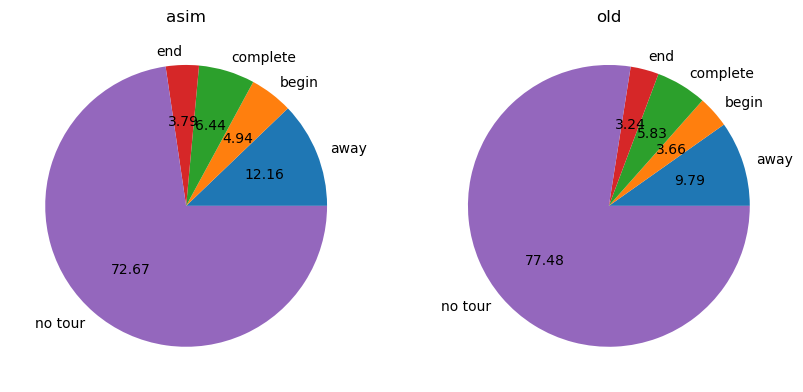

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED].ldt_pattern.value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}).sort_index()
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
temp = old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)].ldt_pattern.value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"}).sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

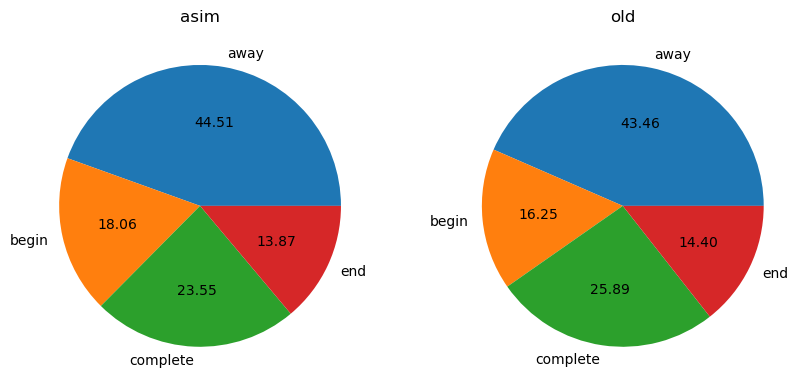

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_persons[asim_persons.ldt_tour_gen_person_WORKRELATED].ldt_pattern.value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}).drop("no tour").sort_index()
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
temp = old_persons[(old_persons.LD_INDICATOR_WORKRELATED == 1)].ldt_pattern.value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"}).drop("no tour").sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

proportions still vary slightly for workrelated pattern despite the model being frequency based

# other patterns

In [30]:
# this ordering is probably right
old_persons[(old_persons.LD_INDICATOR_OTHER == 1)].ldt_pattern.value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"})

no tour     859476
away         52068
complete     41235
begin        16835
end          13485
Name: ldt_pattern, dtype: int64

In [31]:
asim_persons[asim_persons.ldt_tour_gen_person_OTHER].ldt_pattern.value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"})

no tour     211509
away         13039
complete     10427
begin         4158
end           3251
Name: ldt_pattern, dtype: int64

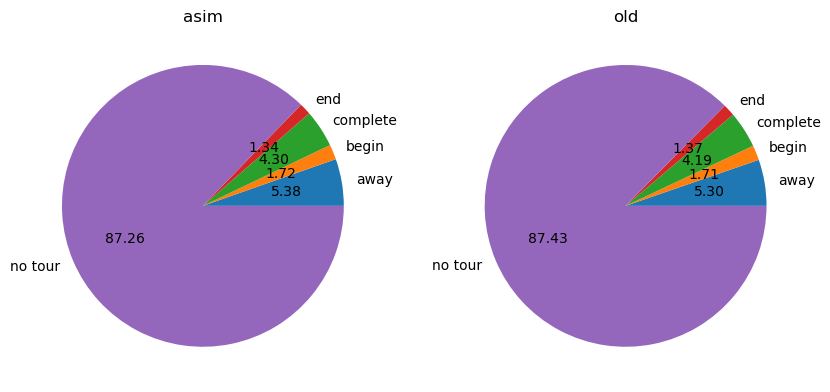

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_persons[asim_persons.ldt_tour_gen_person_OTHER].ldt_pattern.value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}).sort_index()
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
temp = old_persons[(old_persons.LD_INDICATOR_OTHER == 1)].ldt_pattern.value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"}).sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

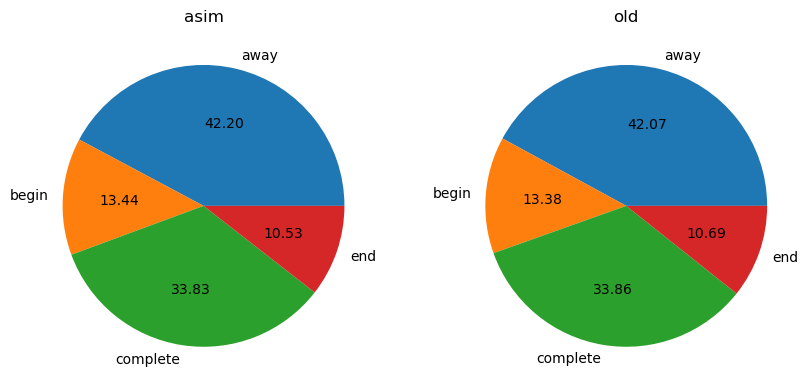

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_persons[asim_persons.ldt_tour_gen_person_OTHER & ~asim_persons.ldt_tour_gen_person_WORKRELATED].ldt_pattern.value_counts().rename(index={0: "no tour", 4: "away", 1: "begin", 2: "end", 3: "complete"}).drop("no tour").sort_index()
axs[0].title.set_text("asim")
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
temp = old_persons[(old_persons.LD_INDICATOR_OTHER == 1) & (old_persons.LD_INDICATOR_WORKRELATED == 0)].ldt_pattern.value_counts().rename(index={0:"complete", 1: "begin", 2:"end", 3:"away", 4:"no tour"}).drop("no tour").sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

generally, asim pattern proportions seem to follow what was defined in java/the specfiication files -- differences from java could be due to downstream propogation of error

# scheduling

In [34]:
# merging bitshifted patterns
asim_results["ldt_pattern"] = np.where(asim_results["ldt_pattern"].isin([8, 16]), 0, asim_results["ldt_pattern"])
asim_results["ldt_pattern"] = np.where(asim_results["ldt_pattern"].isin([9, 17]), 1, asim_results["ldt_pattern"])
asim_results["ldt_pattern"] = np.where(asim_results["ldt_pattern"].isin([10, 18]), 2, asim_results["ldt_pattern"])
asim_results["ldt_pattern"] = np.where(asim_results["ldt_pattern"].isin([11, 19]), 3, asim_results["ldt_pattern"])
asim_results["ldt_pattern"] = np.where(asim_results["ldt_pattern"].isin([12, 20]), 4, asim_results["ldt_pattern"])

In [35]:
# start tours

In [36]:
asim_results[asim_results.ldt_pattern == 1].ldt_start_hour.value_counts()

9     465
8     463
17    387
7     378
10    351
18    312
6     293
16    283
12    260
13    230
15    230
14    223
11    171
5     128
19     94
4      92
20     42
21     28
3      21
2       9
23      8
1       5
22      3
0       2
Name: ldt_start_hour, dtype: int64

In [37]:
old_results["start_hour"] = old_results.departureTime / 100

In [38]:
old_results[old_results.patternType == "BEGIN_TOUR"].start_hour.value_counts()

9.0     2506
8.0     2364
10.0    1829
7.0     1817
17.0    1618
15.0    1334
6.0     1216
12.0    1129
18.0    1088
13.0    1034
16.0     917
11.0     727
14.0     712
19.0     557
5.0      517
4.0      399
20.0     159
21.0     106
3.0       92
2.0       48
1.0       35
22.0      21
0.0       19
23.0      18
Name: start_hour, dtype: int64

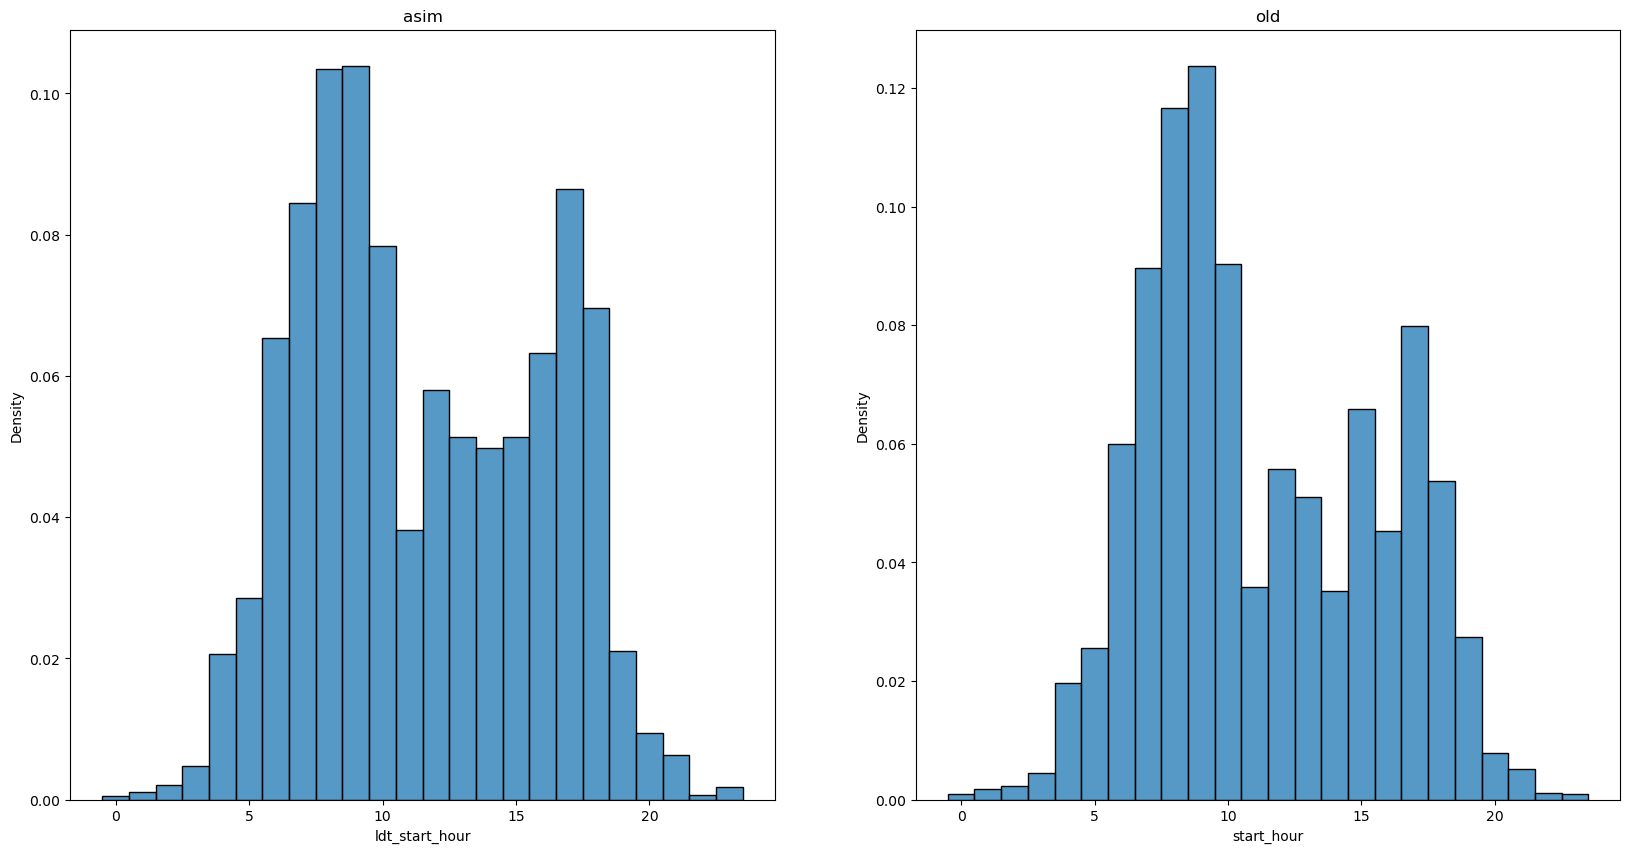

In [39]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
sns.histplot(asim_results[asim_results.ldt_pattern == 1].ldt_start_hour, ax=axs[0], stat="density", discrete=True)
axs[0].title.set_text("asim")
sns.histplot(old_results[old_results.patternType == "BEGIN_TOUR"].start_hour, ax=axs[1], stat="density", discrete=True)
axs[1].title.set_text("old")

begin pattern start hour distribution is roughly identical between old/asim

In [40]:
# end tours

In [41]:
asim_results[asim_results.ldt_pattern == 2].ldt_end_hour.value_counts()

8     375
7     292
10    286
9     268
16    233
17    228
18    222
6     203
12    196
15    192
14    176
13    172
5     134
19    126
11    116
0      71
20     52
21     52
1      40
2      31
4      29
22     27
23     25
3      18
Name: ldt_end_hour, dtype: int64

In [42]:
old_results["end_hour"] = old_results.arrivalTime / 100
old_results[old_results.patternType == "END_TOUR"].end_hour.value_counts()

8.0     2113
10.0    1390
7.0     1323
9.0     1299
6.0     1109
17.0    1081
15.0    1008
12.0     882
16.0     845
14.0     724
18.0     712
13.0     643
5.0      580
11.0     557
19.0     433
0.0      276
20.0     264
21.0     200
2.0      175
1.0      172
22.0     160
4.0      154
23.0     134
3.0       68
Name: end_hour, dtype: int64

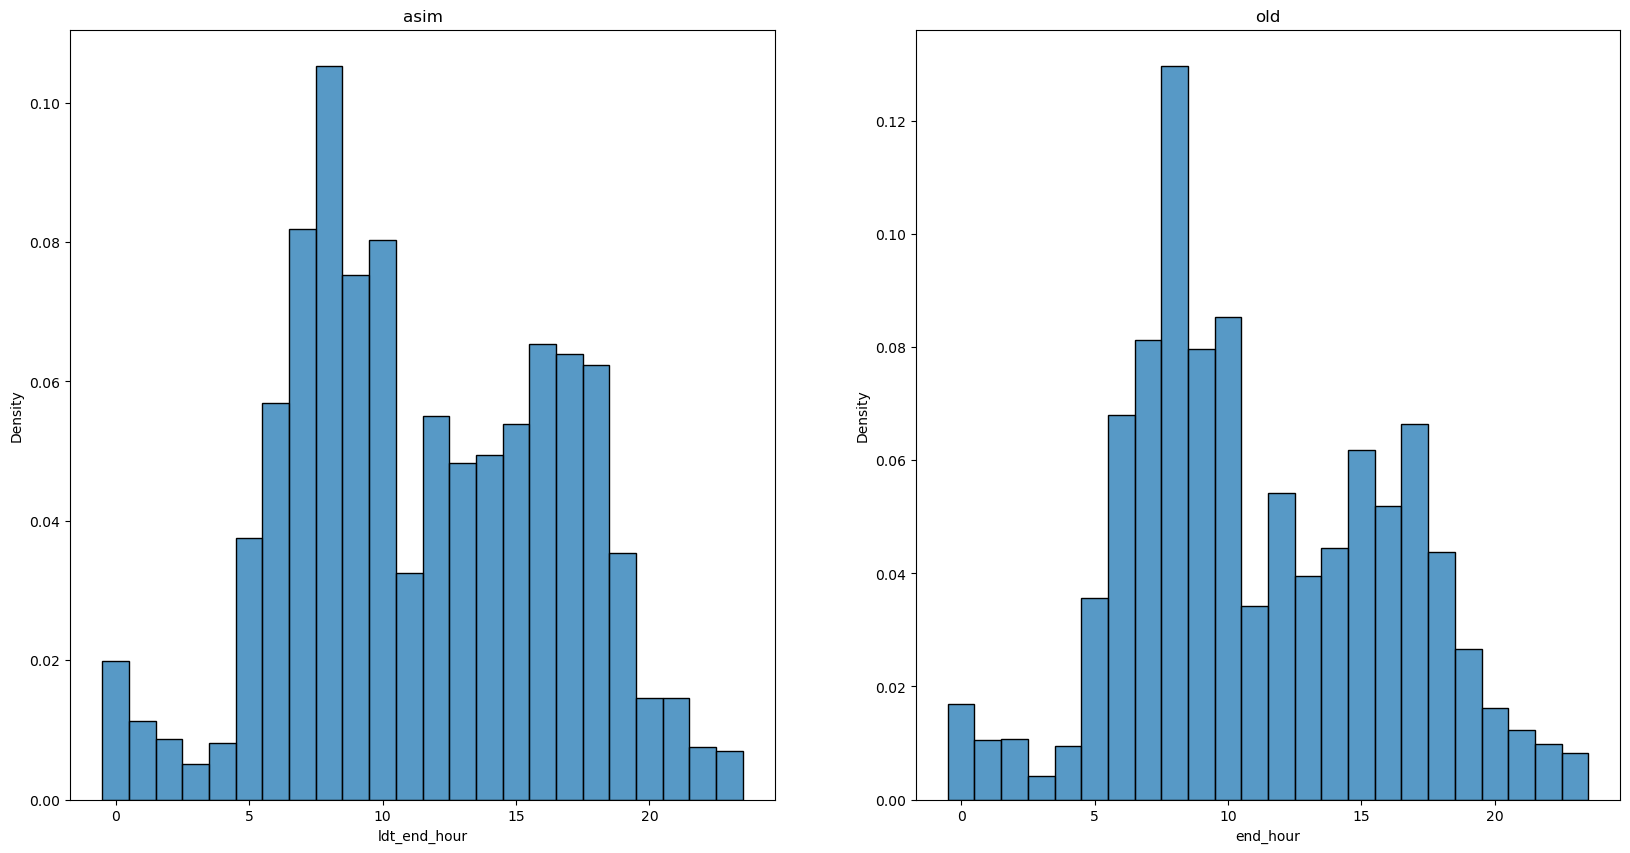

In [43]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
sns.histplot(asim_results[asim_results.ldt_pattern == 2].ldt_end_hour, ax=axs[0], stat="density", discrete=True)
axs[0].title.set_text("asim")
sns.histplot(old_results[old_results.patternType == "END_TOUR"].end_hour, ax=axs[1], stat="density", discrete=True)
axs[1].title.set_text("old")

end pattern end hour distribution is roughly identical between old/asim

In [44]:
## complete

In [45]:
asim_results[asim_results.ldt_pattern == 3].ldt_start_hour.value_counts()

9     2357
8     2147
7     1004
10     937
11     839
12     654
15     579
13     460
5      441
6      401
14     331
16     298
17     270
18     109
Name: ldt_start_hour, dtype: int64

In [46]:
old_results[old_results.patternType == "COMPLETE_TOUR"].start_hour.value_counts()

9.0     10836
8.0     10713
7.0      4570
10.0     3413
11.0     3394
15.0     2322
12.0     2135
13.0     2051
6.0      1744
16.0     1587
5.0      1484
17.0     1223
14.0     1076
18.0      430
Name: start_hour, dtype: int64

In [47]:
asim_results[asim_results.ldt_pattern == 3].ldt_end_hour.value_counts()

20    1857
18    1388
19    1358
17    1299
16    1054
21     798
15     770
22     698
14     584
13     368
23     304
12     193
11     104
10      36
9        9
8        5
7        2
Name: ldt_end_hour, dtype: int64

In [48]:
old_results[old_results.patternType == "COMPLETE_TOUR"].end_hour.value_counts()

20.0    8224
19.0    5838
17.0    5477
18.0    5200
16.0    5073
15.0    3808
21.0    3263
22.0    2945
14.0    2672
13.0    1661
23.0    1245
12.0     914
11.0     386
10.0     204
9.0       47
8.0       17
7.0        4
Name: end_hour, dtype: int64

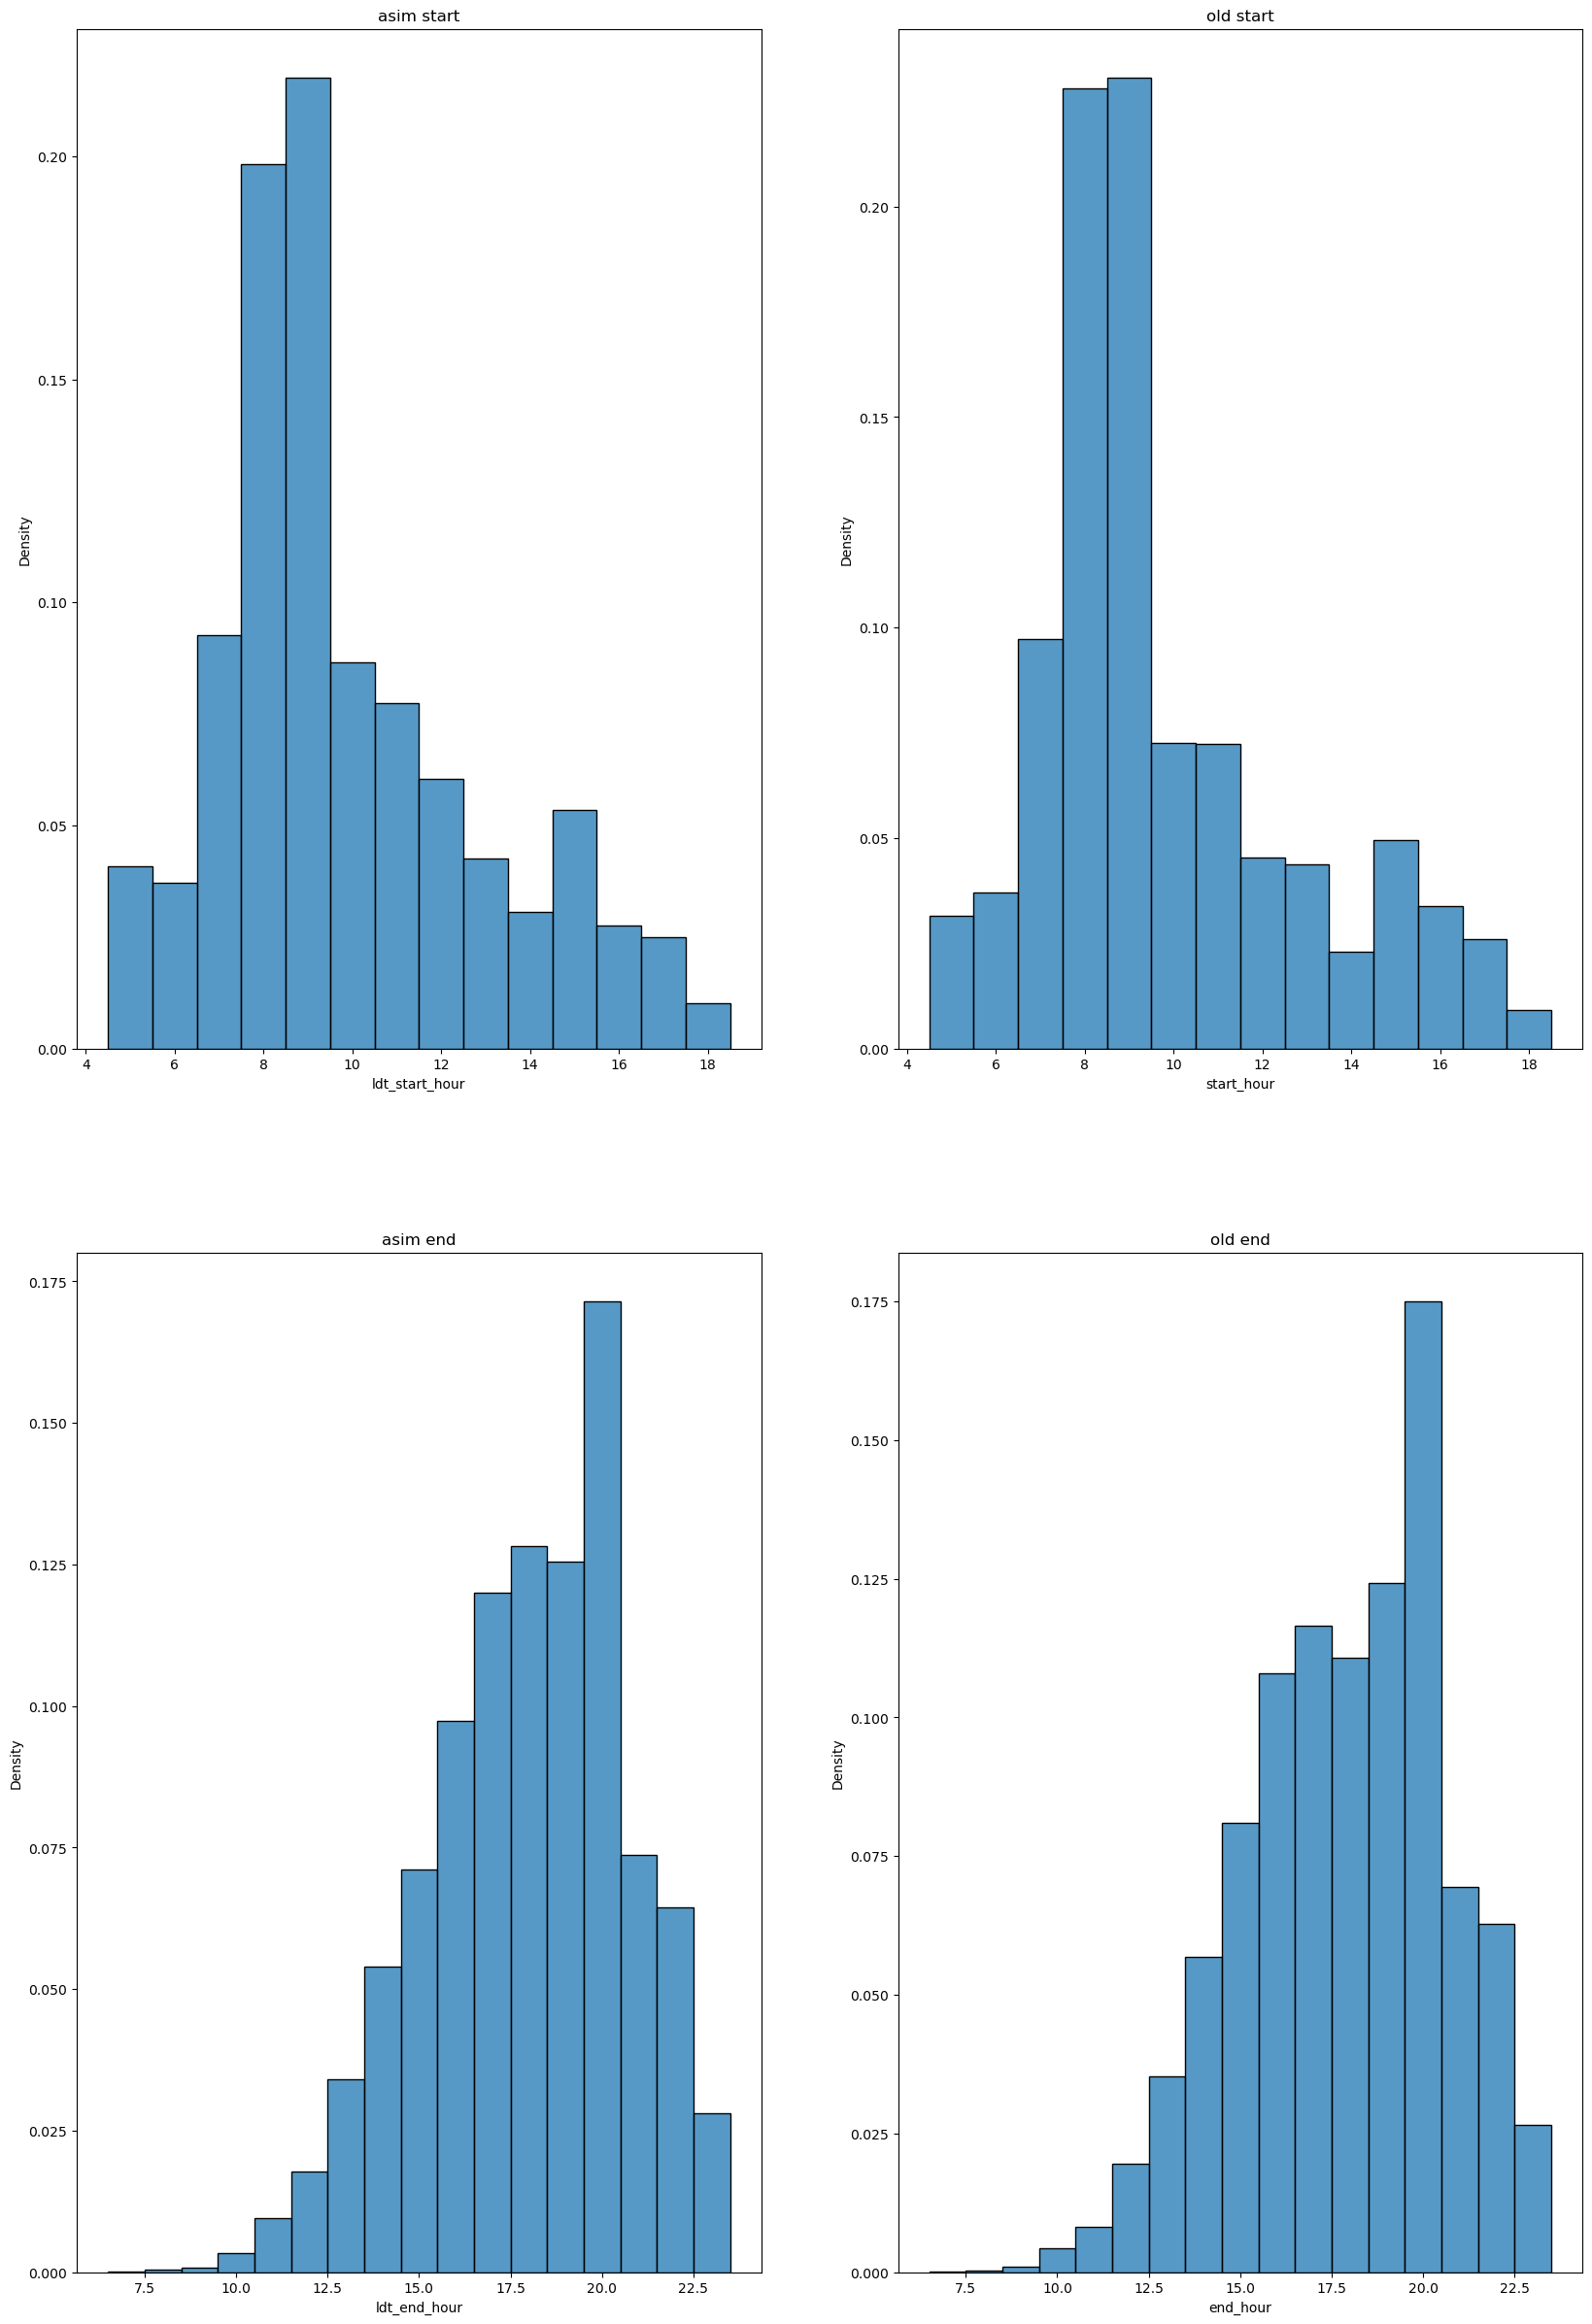

In [49]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 30))
sns.histplot(asim_results[asim_results.ldt_pattern == 3].ldt_start_hour, ax=axs[0, 0], stat="density", discrete=True)
axs[0, 0].title.set_text("asim start")
sns.histplot(old_results[old_results.patternType == "COMPLETE_TOUR"].start_hour, ax=axs[0, 1], stat="density", discrete=True)
axs[0, 1].title.set_text("old start")
sns.histplot(asim_results[asim_results.ldt_pattern == 3].ldt_end_hour, ax=axs[1, 0], stat="density", discrete=True)
axs[1, 0].title.set_text("asim end")
sns.histplot(old_results[old_results.patternType == "COMPLETE_TOUR"].end_hour, ax=axs[1, 1], stat="density", discrete=True)
axs[1, 1].title.set_text("old end")

complete tour start/end hour distributions are about the same

In [50]:
asim_results[asim_results.ldt_pattern == 3][["ldt_start_hour", "ldt_end_hour"]]

,ldt_start_hour,ldt_end_hour
0,9,13
2,18,20
3,18,23
4,13,17
6,12,20
...,...,...
18862,9,21
18864,12,17
18866,18,21
18867,7,13


In [51]:
asim_results["duration"] = np.where(asim_results.ldt_pattern == 3, asim_results["ldt_end_hour"] - asim_results["ldt_start_hour"], 5)

In [52]:
asim_results["duration"].min()

2

In [53]:
asim_results["duration"].max()

18

In [54]:
old_results["duration"] = np.where(old_results.patternType == "COMPLETE_TOUR", old_results["end_hour"] - old_results["start_hour"], 5)

In [55]:
old_results["duration"].min()

2.0

In [56]:
old_results["duration"].max()

17.0

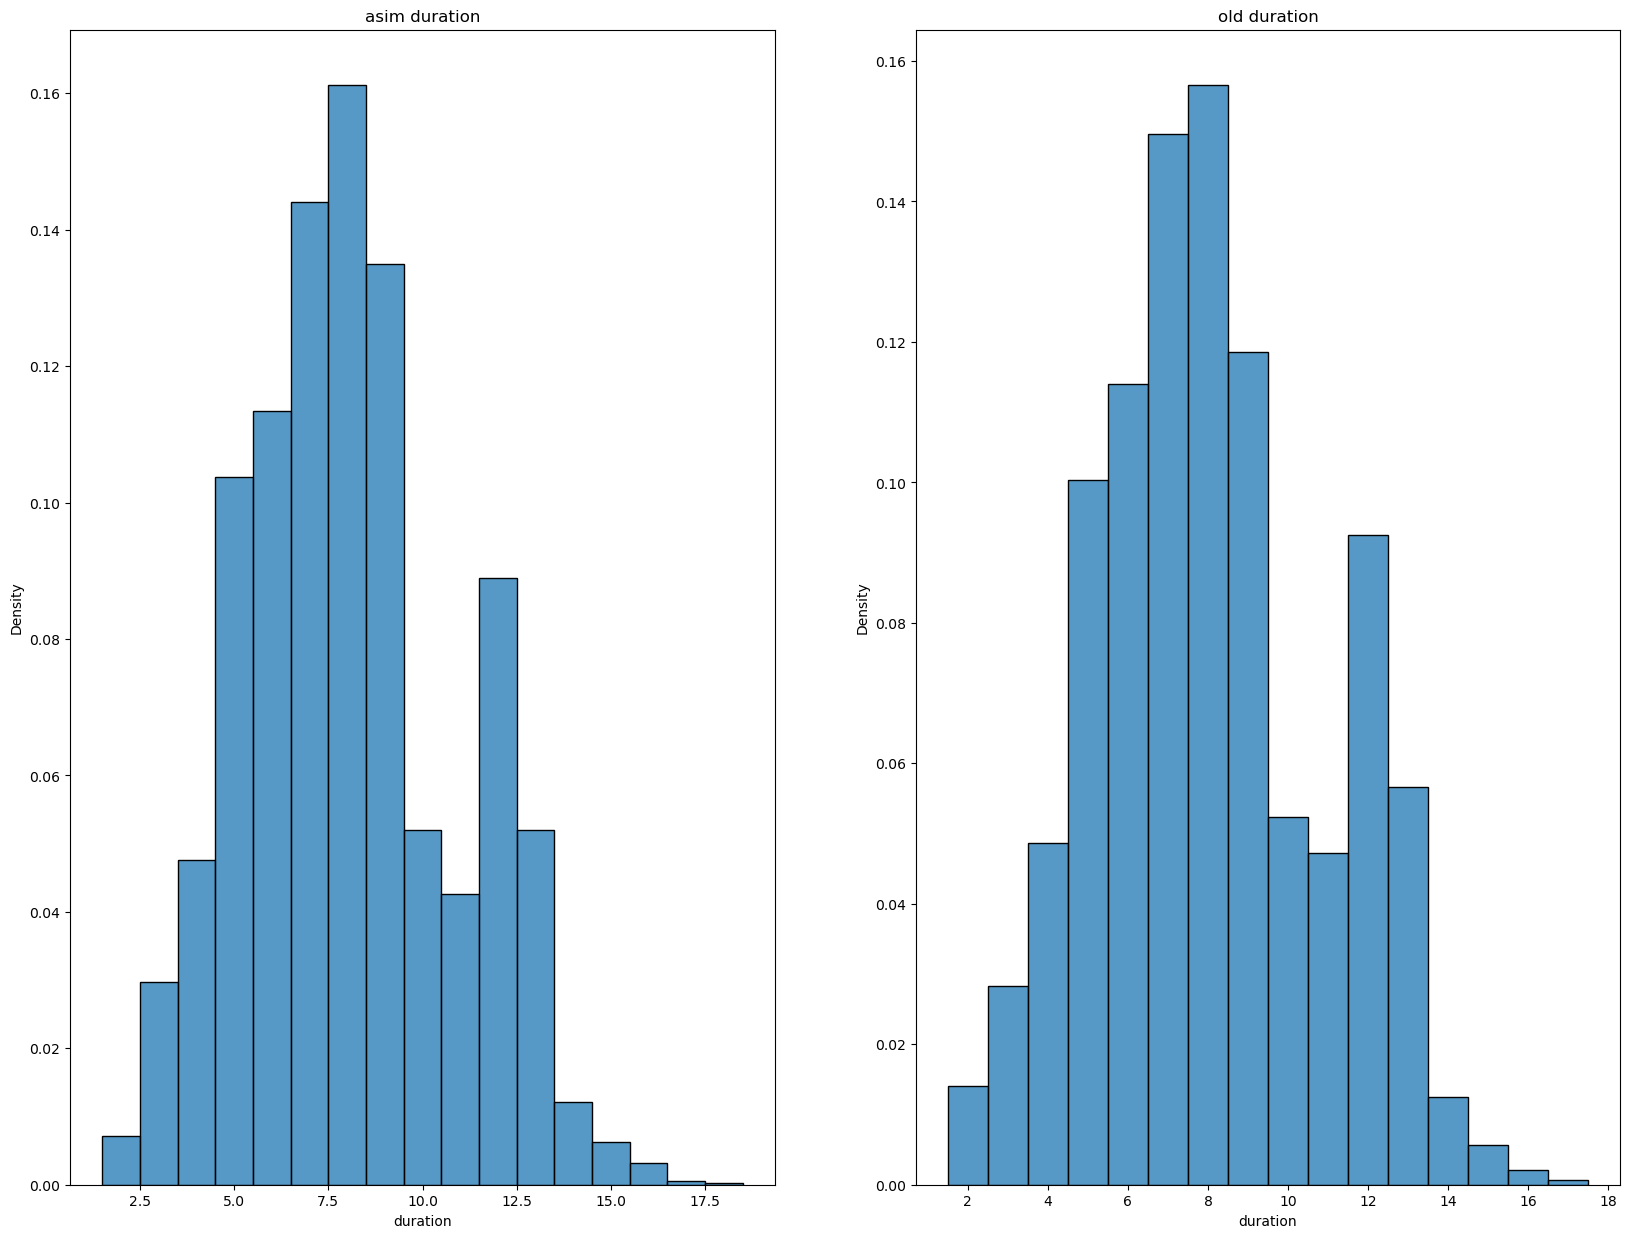

In [57]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 15))
sns.histplot(asim_results[asim_results.ldt_pattern == 3].duration, ax=axs[0], stat="density", discrete=True)
axs[0].title.set_text("asim duration")
sns.histplot(old_results[old_results.patternType == "COMPLETE_TOUR"].duration, ax=axs[1], stat="density", discrete=True)
axs[1].title.set_text("old duration")

complete tour duration distribution seems to be about the same

In [58]:
# internal_external

In [59]:
# 1 external, 0 internal
asim_results.internal_external.value_counts()

0    13787
1     5082
Name: internal_external, dtype: int64

In [60]:
old_results.destinationType.value_counts()

INTERNAL    61167
EXTERNAL    22375
Name: destinationType, dtype: int64

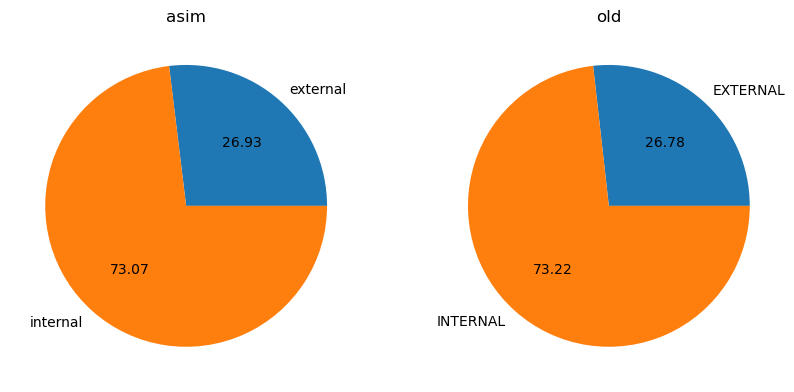

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_results["internal_external"].map(lambda x: "internal" if x == 0 else "external").value_counts().sort_index()
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
axs[0].title.set_text("asim")
temp = old_results["destinationType"].value_counts().sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

internal-external distributions are roughly equal

In [62]:
# external destchoice

In [63]:
asim_results[asim_results.internal_external == 1].external_destchoice.value_counts()

5075    380
5060    224
4269    184
4291    135
4502    132
       ... 
4504      1
3771      1
4324      1
4561      1
3994      1
Name: external_destchoice, Length: 256, dtype: int64

In [64]:
old_results[old_results.destinationType == "EXTERNAL"].destination.value_counts()

4292    1719
4503    1422
4270     787
3998     671
4168     610
        ... 
5053       2
3890       2
5014       1
4293       1
5069       1
Name: destination, Length: 271, dtype: int64

Text(0.5, 1.0, 'old')

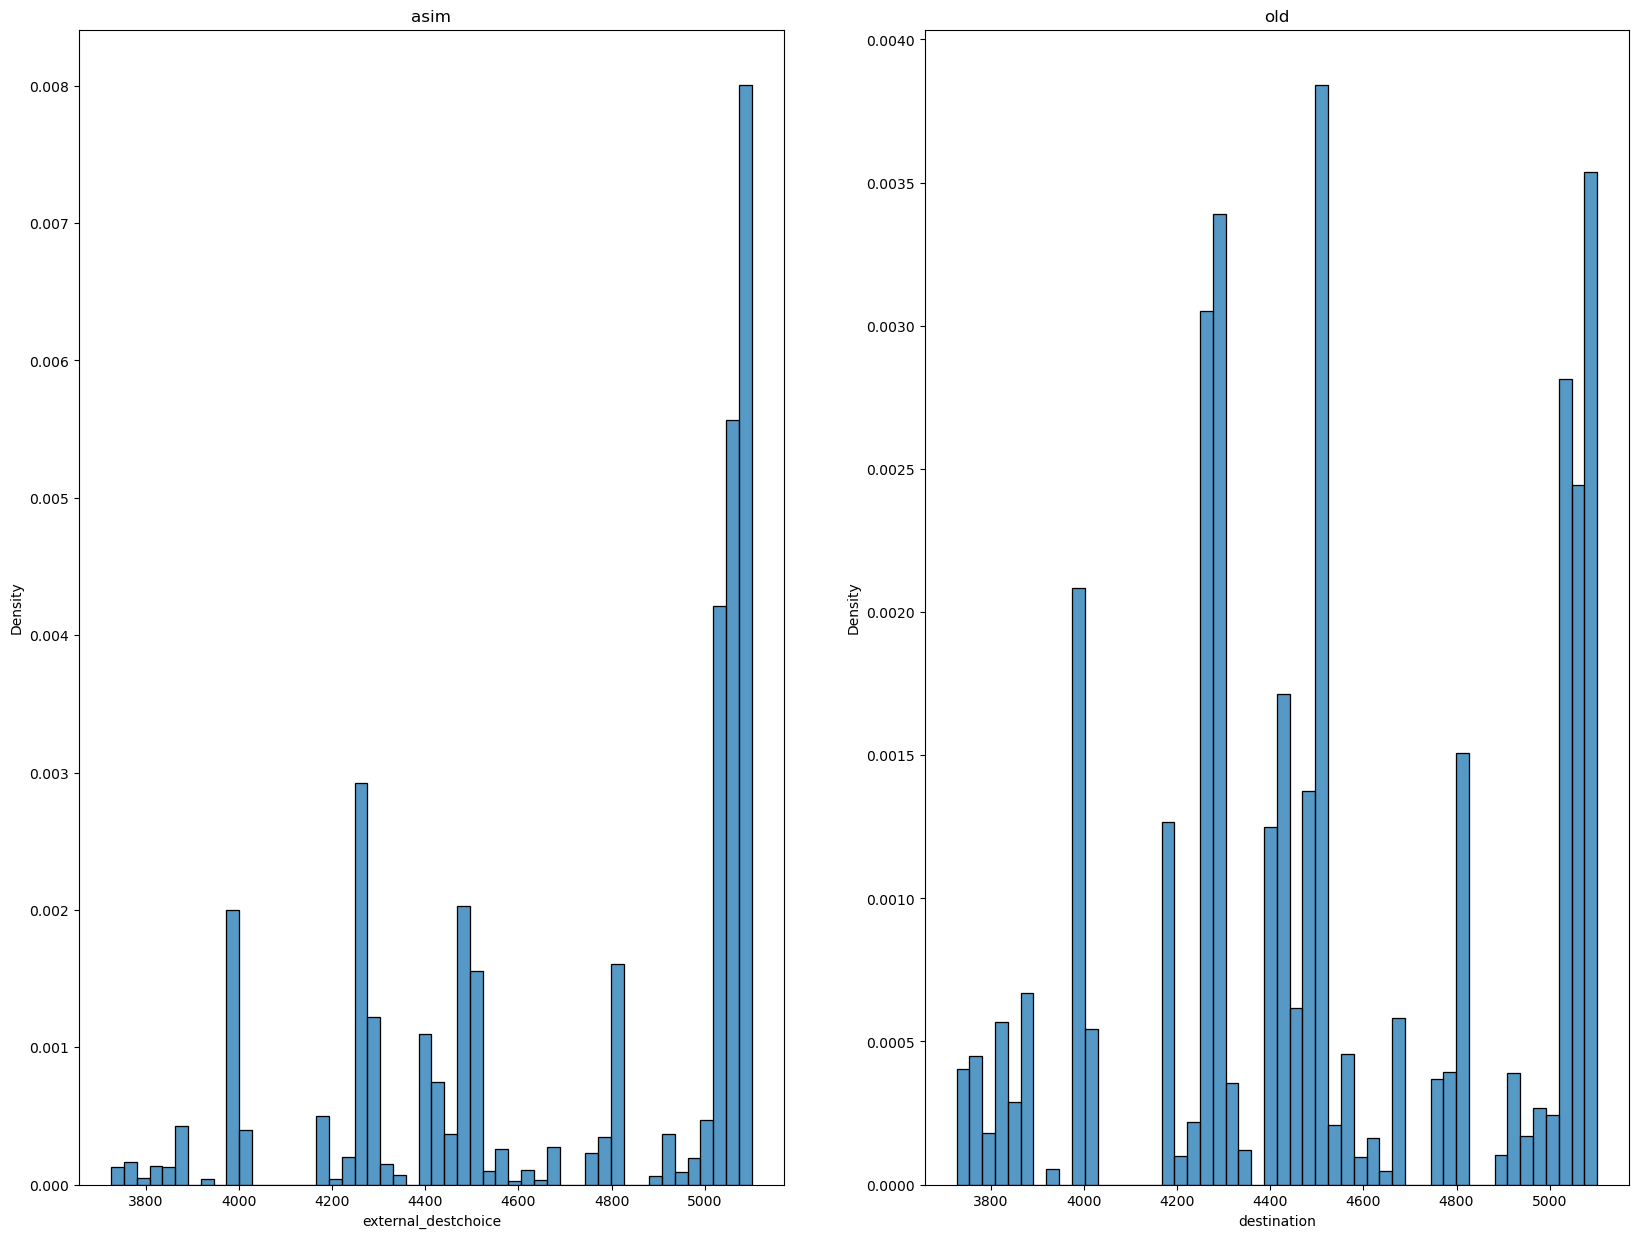

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
sns.histplot(asim_results[asim_results.internal_external == 1].external_destchoice, stat="density", ax=axs[0], bins=50)
axs[0].set_title("asim")
sns.histplot(old_results[old_results.destinationType == "EXTERNAL"].destination, stat="density", ax=axs[1], bins=50)
axs[1].set_title("old")

more people seem to be going to other states in asim for external ldts

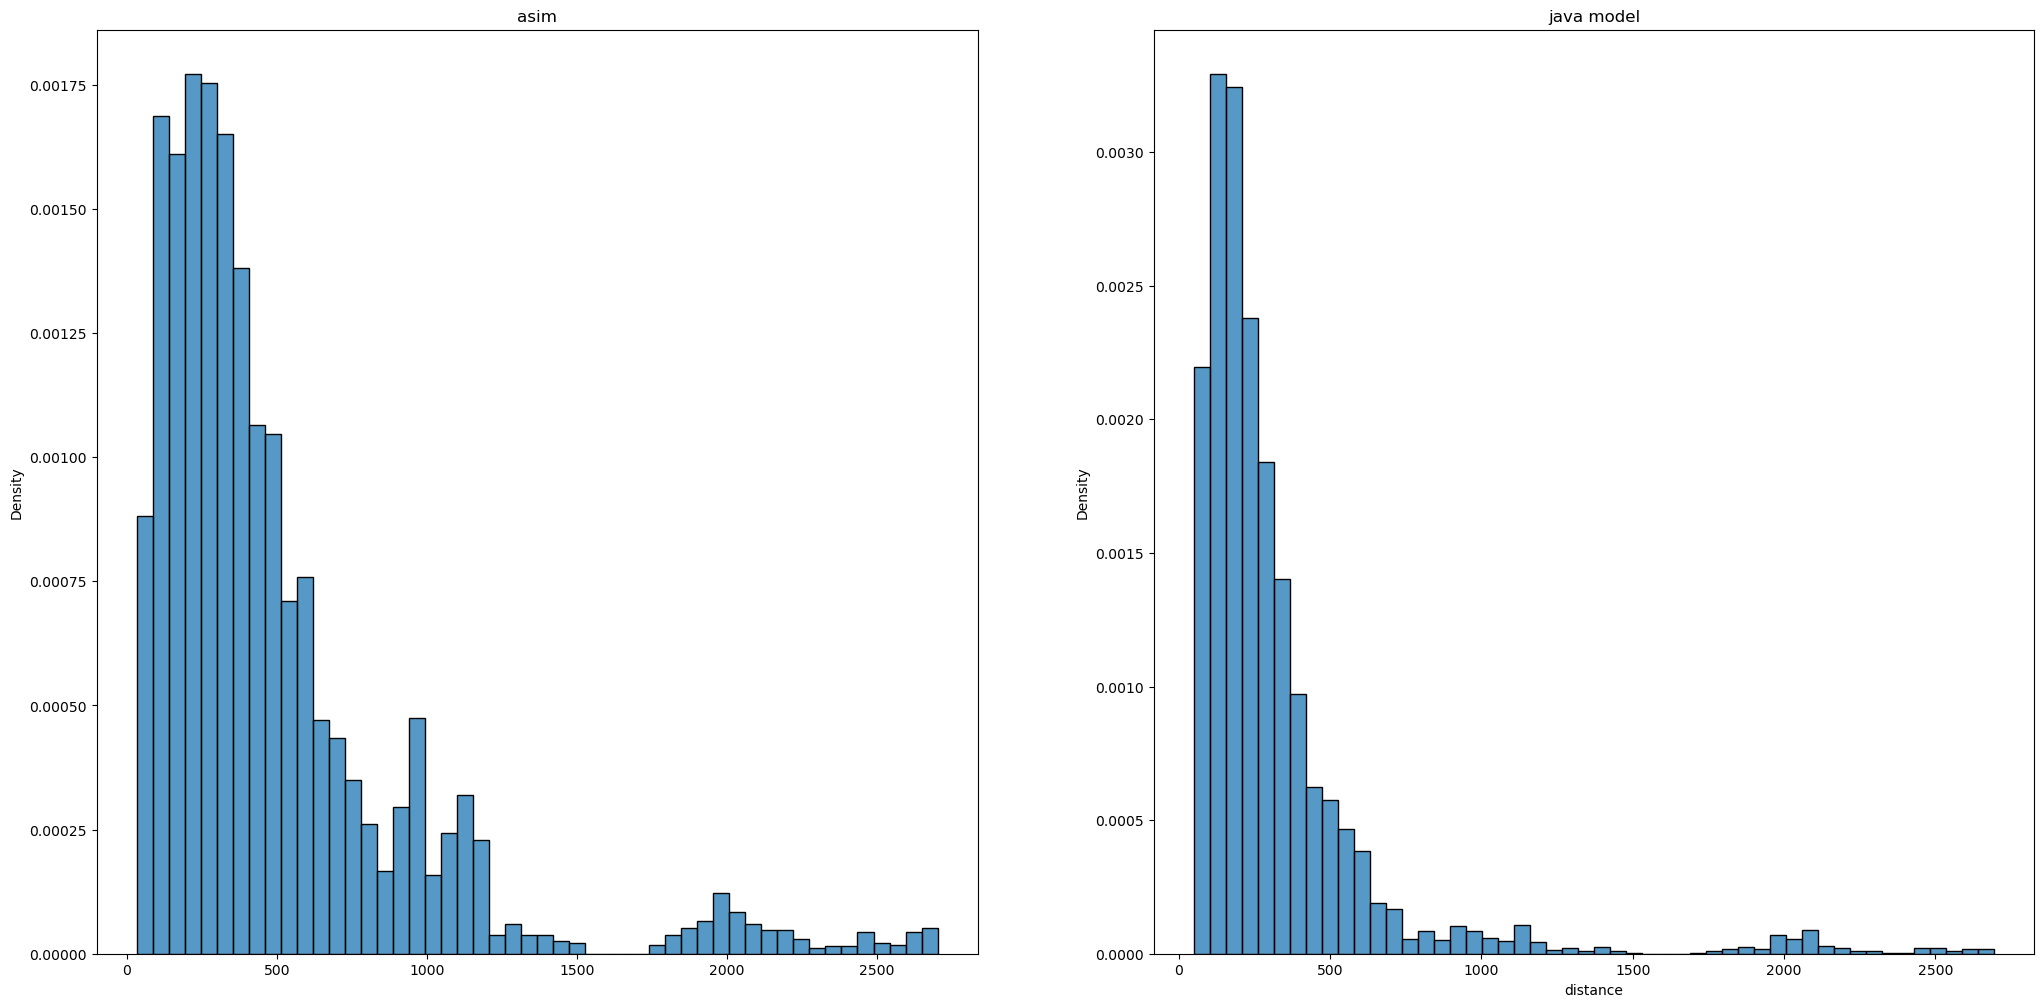

In [66]:
temp = asim_results[asim_results.internal_external == 1]
temp_dist = dists.values[temp.origin, temp.external_destchoice]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 12))
sns.histplot(temp_dist, stat="density", ax=axs[0], bins=50)
axs[0].title.set_text("asim")
sns.histplot(old_results[old_results.destinationType == "EXTERNAL"].distance, stat="density", ax=axs[1], bins=50)
axs[1].title.set_text("java model")

Distance distribution seems roughjly the same

In [67]:
# all external LDTs are basically LDTs (greater than 50 miles away or at least about 50)
dists.values[temp.origin, temp.external_destchoice].min()

33.44

# external mode choice

In [68]:
old_results[old_results.destinationType == "EXTERNAL"].tourMode.value_counts()

AUTO             19123
AIR               3207
TRANSIT_WALK        27
TRANSIT_DRIVE       18
Name: tourMode, dtype: int64

In [69]:
asim_results[asim_results.internal_external == 1].external_tour_mode.value_counts()

DRIVE           4469
AIR              611
WALK_TRANSIT       2
Name: external_tour_mode, dtype: int64

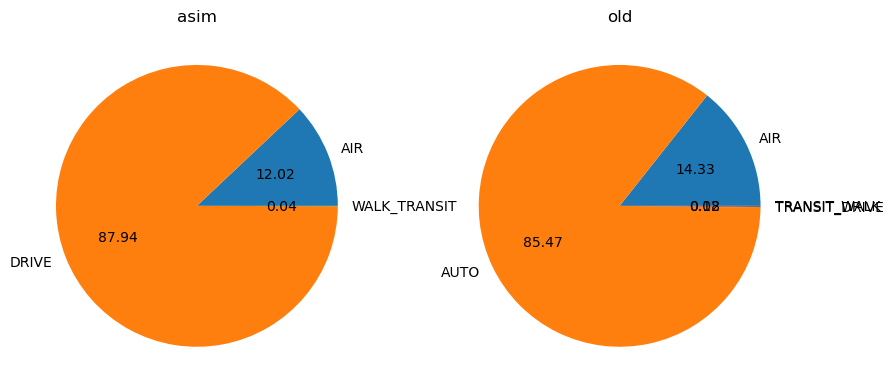

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
temp = asim_results[asim_results.internal_external == 1].external_tour_mode.value_counts().sort_index()
axs[0].pie(temp, labels=temp.index, autopct='%.2f')
axs[0].title.set_text("asim")
temp = old_results[old_results.destinationType == "EXTERNAL"].tourMode.value_counts().sort_index()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index, autopct='%.2f');

roughly the same external mode choice distributions, although less air

# internal dest choice

In [71]:
asim_results[asim_results.internal_external == 0].internal_destination.value_counts()

4963    166
4866     83
4876     81
4863     65
4153     58
       ... 
1164      1
2968      1
1431      1
1300      1
3177      1
Name: internal_destination, Length: 3150, dtype: int64

In [72]:
old_results[old_results.destinationType == "INTERNAL"].destination.value_counts()

1070    384
1201    339
1016    333
1059    305
1066    243
       ... 
4928      1
2425      1
2475      1
4150      1
3578      1
Name: destination, Length: 3996, dtype: int64

<AxesSubplot: xlabel='destination', ylabel='Density'>

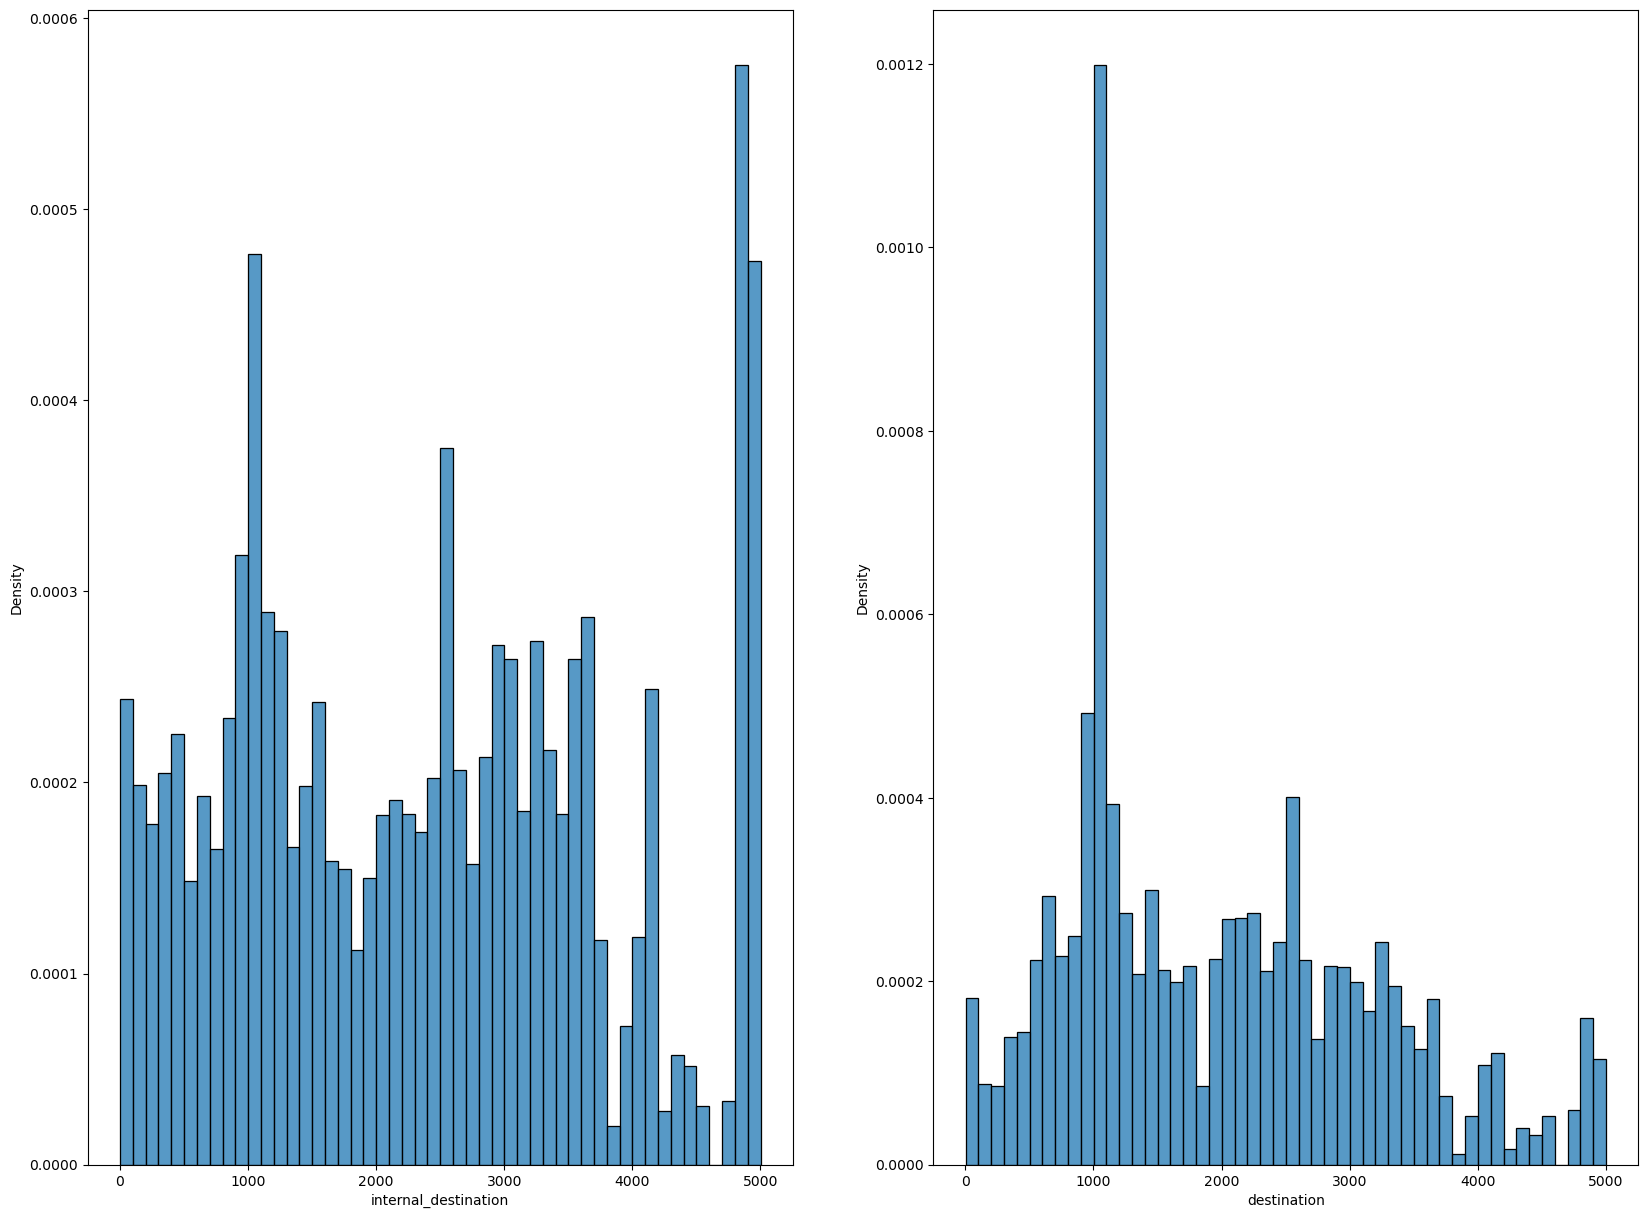

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
sns.histplot(asim_results[asim_results.internal_external == 0].internal_destination, stat="density", ax=axs[0], bins=50)
sns.histplot(old_results[old_results.destinationType == "INTERNAL"].destination, stat="density", ax=axs[1], bins=50)

seems ot be a lot more people going to the 4800+ TAZs in asim

In [74]:
lu = pd.read_parquet(data_path/"land_use.parquet").set_index("TAZ")

In [75]:
# all internal trips are indeed internal
lu.loc[
    asim_results[asim_results.internal_external == 0].internal_destination.value_counts().index+1
]["MODELAREA"].value_counts()

1.0    3150
Name: MODELAREA, dtype: int64

In [76]:
# all external trips are indeed external
lu.loc[
    asim_results[asim_results.internal_external == 1].external_destchoice.value_counts().index+1
]["MODELAREA"].value_counts()

Series([], Name: MODELAREA, dtype: int64)

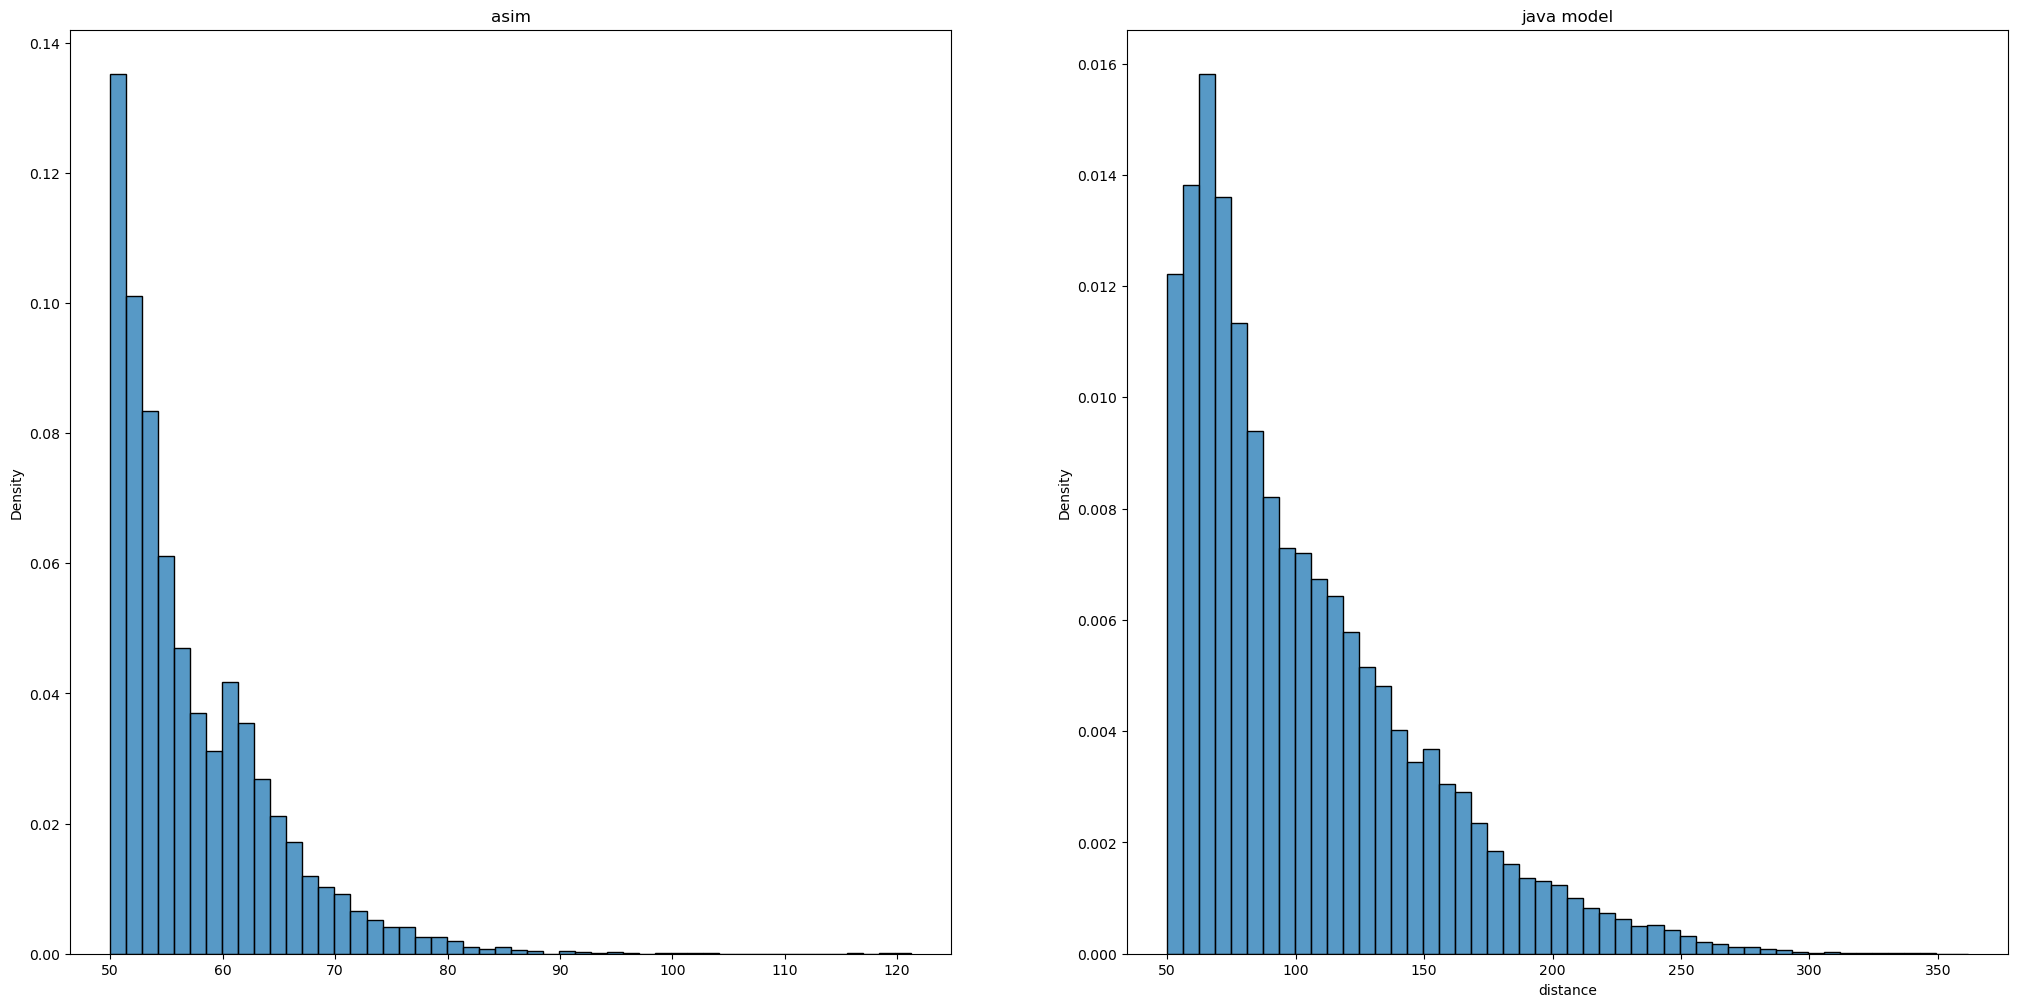

In [77]:
temp = asim_results[asim_results.internal_external == 0]
trip_dists = dists.values[temp.origin, temp.internal_destination]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 12))
sns.histplot(trip_dists, stat="density", ax=axs[0], bins=50)
axs[0].title.set_text("asim")
sns.histplot(old_results[old_results.destinationType == "INTERNAL"].distance, stat="density", ax=axs[1], bins=50)
axs[1].title.set_text("java model")

asim seems to exhibit significantly more distance decay than java

# internal mode choice

In [78]:
old_results[old_results.destinationType == "INTERNAL"].tourMode.value_counts()

AUTO             60755
AIR                149
TRANSIT_WALK       140
TRANSIT_DRIVE      122
HSR_DRIVE            1
Name: tourMode, dtype: int64

In [79]:
asim_results[asim_results.internal_external == 0].tour_mode.value_counts()

PRIVATEAUTO      13704
DRIVE_TRANSIT       57
WALK_TRANSIT        14
DRIVE_HSR           12
Name: tour_mode, dtype: int64

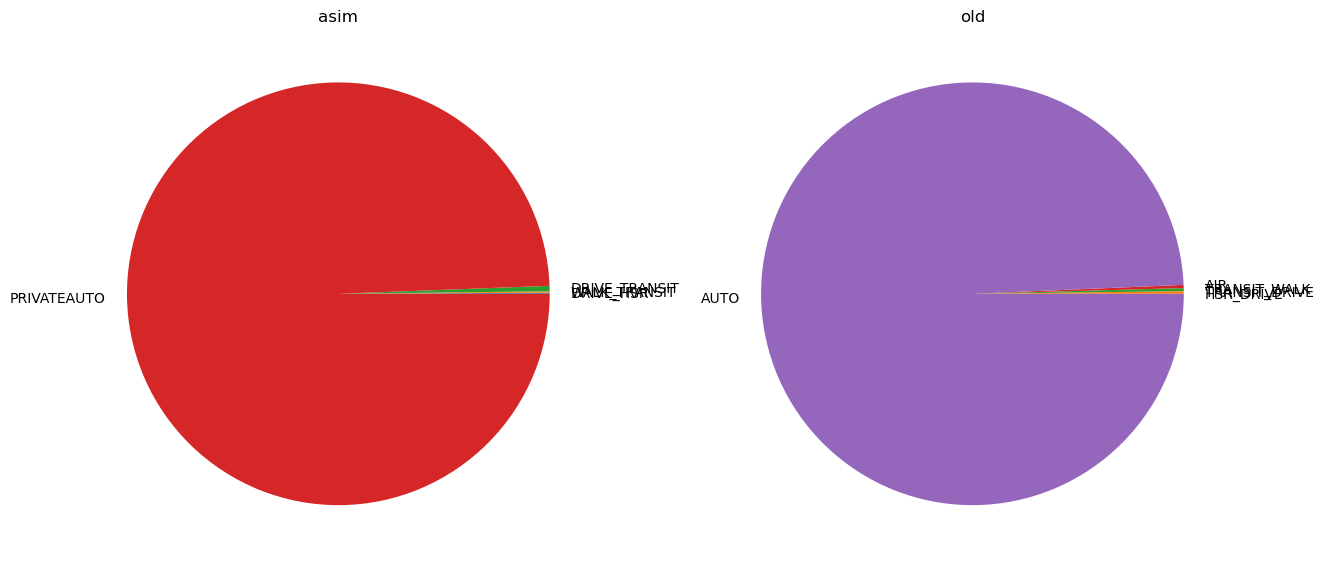

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
temp = asim_results[asim_results.internal_external == 0].tour_mode.value_counts().sort_values()
axs[0].pie(temp, labels=temp.index)
axs[0].title.set_text("asim")
temp = old_results[old_results.destinationType == "INTERNAL"].tourMode.value_counts().sort_values()
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index);

In [81]:
asim_results[asim_results.internal_external == 0].tour_mode.value_counts()

PRIVATEAUTO      13704
DRIVE_TRANSIT       57
WALK_TRANSIT        14
DRIVE_HSR           12
Name: tour_mode, dtype: int64

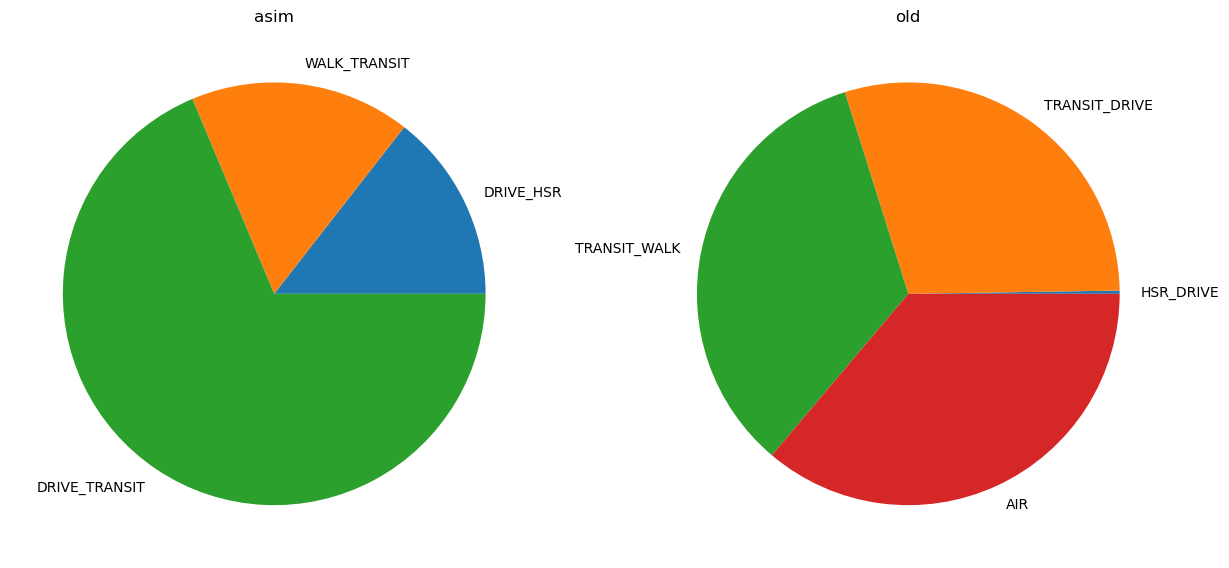

In [82]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
temp = asim_results[asim_results.internal_external == 0].tour_mode.value_counts().sort_values().drop("PRIVATEAUTO")
axs[0].pie(temp, labels=temp.index)
axs[0].title.set_text("asim")
temp = old_results[old_results.destinationType == "INTERNAL"].tourMode.value_counts().sort_values().drop("AUTO")
axs[1].title.set_text("old")
axs[1].pie(temp, labels=temp.index);

roughly the same macro-level distribution, but asim curiously doesn't have any air trips \\ 
could be a downstream effect of lower workrelated trips